<a href="https://colab.research.google.com/github/vilsonrodrigues/NetworkAnalysis/blob/main/spotify-playlists/Spotify_Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@vilsonrodrigues

Esse trabalho é referente a disciplina Network Analysis. Ele aplica um estudo sobre a interação de artistas presentes em playlists no Spotify. Em 2018, o Spotify tornou público o Spotify Million Playlists. 

https://www.aicrowd.com/challenges/spotify-m

Esse dataset possui informações das playlists, como identificador de playlist, nome do autor, nome música, do artista, entre outros. 

Busquei gerar dados quantitativos sobre a Network gerada. O grafo é do tipo unDirected, ou seja não estamos considerando origem e destino das ligações dos Nodes. 

Weights foram considerados. Os weights representam a força da conexão entre os artistas. Quando em uma playlist tem um artista X e o artista Y, sendo que o artista Y aparece 2 vezes, ou seja, ele possui 2 músicas nessa playlist, então, o weight entre eles vai valer  3 (1 + 2). X e Y também irão ter um selfloop, o X vai ter um selfloop de 1 e o Y de 2.

Por fim, foi gerado usando o Gephi uma rede interativa. O deploy dela foi feito usando o Github Pages e pode ser acessado nesse link 

https://vilsonrodrigues.github.io/NetworkAnalysis/spotify-playlists/network

Os códigos base de análise foram fornecidos pelo professor da disciplina e pode ser encontrado em seu repositório no Github https://github.com/ivanovitchm 

## Install and import libs

Após a instalação reinicie o runtime

In [ ]:
!pip install nxviz==0.6.3
!pip install matplotlib==3.1.3
!pip install pandas==1.3.0

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import networkx as nx
import nxviz
from nxviz.plots import CircosPlot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import joblib

## Step 0 | Data Preparing

Download da base de um sample dos dados disponibilizados pelo Spotify. Thanks Vaslnk

In [ ]:
!wget https://raw.githubusercontent.com/vaslnk/Spotify-Song-Recommendation-ML/master/data/mpd.slice.0-999.json

--2022-01-15 15:44:43--  https://raw.githubusercontent.com/vaslnk/Spotify-Song-Recommendation-ML/master/data/mpd.slice.0-999.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34119368 (33M) [text/plain]
Saving to: ‘mpd.slice.0-999.json’

mpd.slice.0-999.jso 100%[===================>]  32.54M   178MB/s    in 0.2s    

2022-01-15 15:44:44 (178 MB/s) - ‘mpd.slice.0-999.json’ saved [34119368/34119368]



Lendo essa slice

In [ ]:
#Read in json splice and transform into a playlist level dataframe
start = 0
end = 1000
path = 'mpd.slice.' + str(start) + "-" + str(end-1) + '.json'
d = json.load(open(path, 'r'))

Chaves que esse json possui

In [ ]:
print(d.keys())

dict_keys(['info', 'playlists'])


In [ ]:
print(str(d)[:300])

{'info': {'generated_on': '2017-12-03 08:41:42.057563', 'slice': '0-999', 'version': 'v1'}, 'playlists': [{'name': 'Throwbacks', 'collaborative': 'false', 'pid': 0, 'modified_at': 1493424000, 'num_tracks': 52, 'num_albums': 47, 'num_followers': 1, 'tracks': [{'pos': 0, 'artist_name': 'Missy Elliott'


In [ ]:
df = pd.DataFrame.from_dict(d['playlists'], orient='columns')

**Amostra dos dados em formato de DataFrame**

Os campos são:

* name: nome da playlist
* collaborative: se a playlist é colaborativa ou não
* pid: playlist identificador
* modified_at: quando foi modificado. Horário unix
* num_tracks: número de músicas 
* num_followers: número de seguidores da playlist
* tracks: campo com informações das músicas. Mais detalhes a seguir
* num_edits: quantas vezes ela foi editada
* duration_ms: tempo total da playlist em ms
* num_artists: número de artistas na playlist
* description: descrição da playlist

In [ ]:
df.sample(5)

Chaves do campo Track em cada playlist

* album_name: nome do álbum
* album_uri: endereço URI do álbum
* artist_name: nome do artista
* artist_uri: endereço URI do artista
* duration_ms: duração da música
* pos: posição da música na playlist
* track_name: nome da música
* track_uri: endereço URI da música

In [ ]:
df["tracks"][0][0]

{'album_name': 'The Cookbook',
 'album_uri': 'spotify:album:6vV5UrXcfyQD1wu4Qo2I9K',
 'artist_name': 'Missy Elliott',
 'artist_uri': 'spotify:artist:2wIVse2owClT7go1WT98tk',
 'duration_ms': 226863,
 'pos': 0,
 'track_name': 'Lose Control (feat. Ciara & Fat Man Scoop)',
 'track_uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI'}

Número de playlists nesse sample

In [ ]:
len(df["pid"].unique())

1000

Extraindo os dados que vamos usar

In [ ]:
def extract_features(df):
  playlistsAndTracks = []
  for _, row  in df.iterrows():
    for track in row['tracks']:
      playlistsAndTracks.append([row['pid'], row['name'], track['track_uri'], row["num_tracks"],  track['album_name'], track['artist_name'], track['track_name']])
  return pd.DataFrame(playlistsAndTracks, columns=['pid', 'name', 'track_id','num_tracks', 'album_name', 'artist_name', 'track_name'])  

In [ ]:
df_playlistsAndTracks = extract_features(df)

Esses dados contem o $ nas strings, o matplotlib interpreta como uma operação de escrita matemática. É necessário retirar 

In [ ]:
df_playlistsAndTracks['artist_name'] = df_playlistsAndTracks['artist_name'].str.replace('\$\$','').str.replace('\$','')
df_playlistsAndTracks['name'] = df_playlistsAndTracks['name'].str.replace('\$\$','').str.replace('\$','')
df_playlistsAndTracks['album_name'] = df_playlistsAndTracks['album_name'].str.replace('\$\$','').str.replace('\$','')
df_playlistsAndTracks['track_name'] = df_playlistsAndTracks['track_name'].str.replace('\$\$','').str.replace('\$','')

In [ ]:
df_playlistsAndTracks.sample(5)

pid  ...                                    track_name
30354  456  ...                                    Beach Bums
12389  190  ...                                       Hol' Up
25454  401  ...  In My Head (feat. Georgia Ku) - Landis Remix
3053    53  ...                                          Pony
31201  468  ...     Trndsttr (feat. M. Maggie) - Lucian Remix

[5 rows x 7 columns]

Quantidade de ocorrências de um artista em uma playlist

In [ ]:
df_playlistsAndTracks[df_playlistsAndTracks["pid"]==1].groupby(['artist_name'])["track_id"].count().reset_index(name="occurrences")

artist_name  occurrences
0                     Ben Foster            2
1                         Boston            3
2            Christopher Jackson            1
3                Collective Soul            1
4   Creedence Clearwater Revival            1
5                 Daniel Tidwell            6
6                  Guns N' Roses            1
7                       Kaleptik            1
8                         Kansas            1
9                   Led Zeppelin            2
10               Leslie Odom Jr.            2
11            Lin-Manuel Miranda            1
12                Lynyrd Skynyrd            2
13                     Nightwish            1
14                         Queen            1
15                          Rush            7
16                     Scorpions            1
17                          Seal            1
18                      Survivor            1
19            The Rolling Stones            2
20                          Toto            1

In [ ]:
df_playlistsAndTracks.head(2)

pid        name  ...     artist_name                                  track_name
0    0  Throwbacks  ...   Missy Elliott  Lose Control (feat. Ciara & Fat Man Scoop)
1    0  Throwbacks  ...  Britney Spears                                       Toxic

[2 rows x 7 columns]

In [ ]:
def get_weight_in_edge(node1, node2, G):
  try:
    return G.edges[node1,node2]["weight"] 
  except:
    return 0.0

In [ ]:
#v2
#def get_weight_in_edge(node1, node2, G):
#  if G.has_edge(node1, node2):
#    return G.edges[node1,node2]["weight"] 
#  else:
#    return 0.0

In [ ]:
def make_graph(df):
  G = nx.Graph()
  #Coleta o id para realizar o pivoteamento
  for pid in df["pid"].unique():
    #Pivoteamento apenas de apenas uma playlist por vez
    df_actual_pid = df[df["pid"]==pid]
    #Conta o númnero de vezes que cada artista aparece na playlist
    df_artists_count = df_actual_pid.groupby(["artist_name"])["track_id"].count().reset_index(name="occurrences")
    #Adiciona os Nodes da vez
    G.add_nodes_from(df_artists_count["artist_name"].values)
    #Itera sobre os artistas agrupados
    for artist_name, occurrences in zip(df_artists_count["artist_name"], df_artists_count["occurrences"]):
      for artist_name2, occurrences2 in zip(df_artists_count["artist_name"], df_artists_count["occurrences"]):
        #Coleta o valor na conexão 
        previous_weight = get_weight_in_edge(artist_name, artist_name2, G)
        #Caso de autoloop
        if artist_name == artist_name2:          
          G.add_edge(artist_name, artist_name, weight = previous_weight + occurrences)
          #if artist_name == "Avril Lavigne":
          #  print(artist_name + "  previous" + str(previous_weight))
          #  print(artist_name + "  new" + str(previous_weight+occurrences))
        #Caso geral
        else:          
          G.add_edge(artist_name, artist_name2, weight = previous_weight + occurrences + occurrences2)            
  return G

In [ ]:
G = make_graph(df_playlistsAndTracks)

Realizando algumas perguntas sobre o Graph ao NetworkX

In [ ]:
print("Is connected? ",nx.is_connected(G))

Is connected?  False


In [ ]:
print("How many connected components has G? ",nx.number_connected_components(G))

How many connected components has G?  5


Aqui vemos que o Graph possui 5 Components comprovando o que o Networkx disse anteriormente sobre não ser conectada. 

Abaixo vemos o número de Nodes que cada Component tem e quais são eles



In [ ]:
for component in nx.connected_components(G):
  print(len(component),component)

9697 {'Chelsea Wolfe', 'PJ Harvey', 'Peter Hollens', 'Anarbor', 'Shirley Horn', 'Vertical Horizon', 'Cosmic Gate', 'Dirty South', 'Stars Go Dim', 'Sam Roberts', 'Mike Posner', 'Boricua Boys', 'Dick Van Dyke', 'KO:YU', 'Lyle Lovett', 'Three Dog Night', 'The Acacia Strain', 'Logan Paul', 'Up High Collective', 'Classics IV', 'MoKenStef', 'Beach Tiger', 'HoodRich Pablo Juan', 'Henry Mendez', 'Bipolar Sunshine', 'Voz De Mando', 'Sonny & The Sunsets', 'Woz', 'Maren Morris', 'Sam Gellaitry', 'John Rzeznik', 'The Milk Carton Kids', 'Sister Nancy', 'Dillon Francis', 'DJ Antoine', 'Texas Tornados', 'Haywyre', 'Steven Sharp Nelson', 'Tim Maia', 'Robert Schwartzman', 'Christon Gray', 'Collin Mclouglin', 'Good Old War', 'Patent Pending', 'San Cisco', 'Randy Bright', 'Lenny Tavárez', 'Martyr Defiled', 'JJ Heller', 'Sixx:A.M.', 'Kaaze', 'New Riders of the Purple Sage', 'The Moody Blues', 'Vern Reed', 'Yog', 'Rammstein', 'Renée Elise Goldsberry', 'Chuck Berry', 'Gladys Knight & The Pips', 'Austra', 'J

Vamos analisar o Giant Component Connected (GCC) da rede. Para isso vamos selecionar a subnetwork da primeira posição

In [ ]:
Gcc = list(G.subgraph(c).copy() for c in nx.connected_components(G))[0] 

In [ ]:
print("Is connected? ",nx.is_connected(Gcc))

Is connected?  True


Número de Nodes e Links do GCC

In [ ]:
len(Gcc.nodes),len(Gcc.edges())

(9697, 855159)

## Step 1 | Eccentricity, Periphery, Radius, Center and Diameter

Calculando a melhor posição dos Nodes no plot

In [ ]:
pos = nx.spring_layout(Gcc,seed=123456789)

A cor dele baseada na Exccentricity

In [ ]:
color = list(dict(nx.eccentricity(Gcc)).values())

Os objetos demoram para processar, por via das dúvidas, use o Joblib e salve como pkl

In [ ]:
joblib.dump(pos, 'pos.pkl')

In [ ]:
joblib.dump(color, 'color.pkl')

In [ ]:
nx.write_graphml(Gcc, "Gcc.graphml")

Exporte como Graphml ou como pkl

In [ ]:
#joblib.dump(Gcc, 'Gcc.pkl')

In [ ]:
Gcc = nx.read_graphml("Gcc.graphml")

Se precisar ler de novo

In [2]:
pos = joblib.load('pos.pkl', mmap_mode='r')

In [ ]:
color = joblib.load('color.pkl', mmap_mode='r')

In [3]:
#Gcc = joblib.load('Gcc.pkl', mmap_mode='r')

In [ ]:
Gcc = nx.read_graphml("Gcc.graphml")

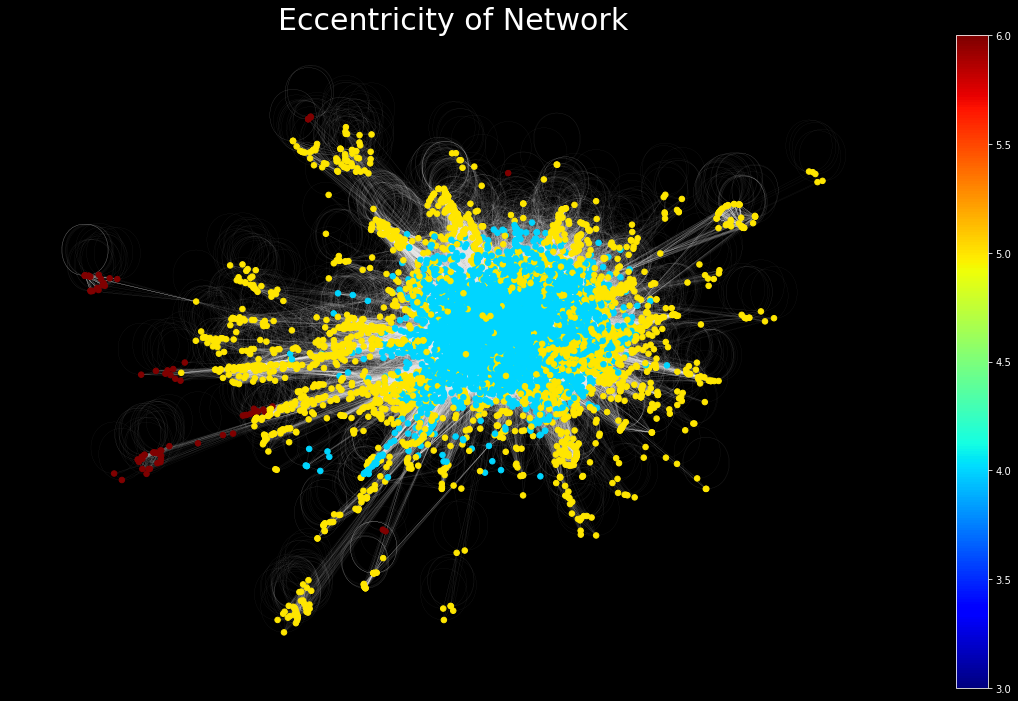

In [ ]:
plt.style.use("dark_background")

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

fig, ax = plt.subplots(1,1,figsize=(20,12))
# draw edges
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.05,
                       alpha=0.6, 
                       ax=ax,
                       edge_color='white')

# draw nodes
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,
                 node_size=30)

# draw labels
#nx.draw_networkx_labels(Gcc, pos=pos,
#                        font_color='white', ax=ax)

plt.title("Eccentricity of Network", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.savefig('eccentricity.jpg',dpi=300)
plt.show()

Na figura acima vemos o plot do nosso GCC. Os Nodes (artistas) estão classificados pela métrica Eccentricity. A Eccentricity é a distância máxima de um Node a todos outros de uma network. A variação na GCC vai desde uma distância de 3 Nodes à uma máxima distância de 6 Nodes

O Diameter é o máximo valor de Eccentricity de uma network. Como vimos no plot esse valor é 6. Podemos confirmar esse valor usando o NetworkX

In [ ]:
print("Diameter of network (Gcc): {}".format(nx.diameter(Gcc)))

Diameter of network (Gcc): 6


Periphery é o conjunto de todos os Nodes que possuem cujo a Eccentricity é igual ao Diameter.

In [ ]:
nx.periphery(Gcc)

['Benita Washington',
 'CeCe Winans',
 'Donald Lawrence',
 'Dottie Peoples & The Peoples Choice Chorale',
 'Florida A&M University Gospel Choir',
 'Kelly Price',
 'Shekinah Glory Ministry',
 'Smokie Norful',
 'Tamela Mann',
 'The Rance Allen Group',
 'The Warriors, DR.Charles G. Hayes',
 'Alex Campos',
 'Daniel Calveti',
 'Danilo Montero',
 'Danny Berrios',
 'En Espíritu Y En Verdad',
 'Ericson Alexander Molano',
 'Inspiraciòn',
 'Jesús Adrián Romero & Marcela Gandara',
 'Jose Luis Reyes',
 'Julio Melgar',
 'Los Hijos Del Rey',
 'Luigi Castro',
 'Luis Santiago',
 'Marcela Gandara',
 'Marco Barrientos',
 'Marco Barrientos & David Luckey',
 'Marcos Witt',
 'Roberto Orellana',
 'Salida 7',
 'Samuel Hernández',
 'Tony Pérez',
 'Vertical',
 'Vino Nuevo',
 'Óscar Medina',
 'Banda Renovacion',
 'Crecer German',
 'Grupo 360',
 'Los Del Arroyo',
 'Los Hijos De Hernández',
 'Los Migueles "La Voz Original"',
 'David Nevue',
 'Paul Cardall',
 'Carlene Carter',
 'Franz Schubert',
 'Aldo Garcia',
 '

Radius é o menor valor de Excentricity de uma network. Como vimos no plot esse valor é 3. No NetworkX podemos achar usando

In [ ]:
print("Radius of network(Gcc): {}".format(nx.radius(Gcc)))

Radius of network(Gcc): 3


Center é o conjunto de todos os Nodes que possuem a Exccentricity igual ao Radius

In [ ]:
nx.center(Gcc)

['Justin Bieber', 'Queen', 'Pitbull', 'Johnny Cash']

## Step 2 | Centrality Distribution: Bivariate Analysis


### 2.1 Degree 

Degree é o número de conexões de um Nó. Os Nodes que possuem os maiores valores de Degree são conhecidos como Hubs (principais Nodes). Vamos ver o top 20 Nodes com maior Degree

In [ ]:
i=0
for k, v in sorted(dict(nx.degree(Gcc)).items(), key=lambda x: x[1],reverse=True):
  print(k,v)
  if i == 20:
    break
  i+=1

Drake 3221
Rihanna 3056
Kanye West 2699
The Weeknd 2667
Coldplay 2590
The Chainsmokers 2505
Kendrick Lamar 2445
Calvin Harris 2414
Maroon 5 2188
Ed Sheeran 2157
Major Lazer 2147
Justin Bieber 2075
Twenty One Pilots 2059
Imagine Dragons 2019
Sia 1958
DJ Snake 1927
J. Cole 1893
Vance Joy 1889
Future 1887
Lil Wayne 1876
Ariana Grande 1875


Cores conforme o Degree de um Node

In [26]:
color_degree = list(dict(nx.degree(Gcc)).values())

In [ ]:
joblib.dump(color_degree, 'color_degree.pkl')

In [ ]:
color_degree = joblib.load('color_degree.pkl', mmap_mode='r')

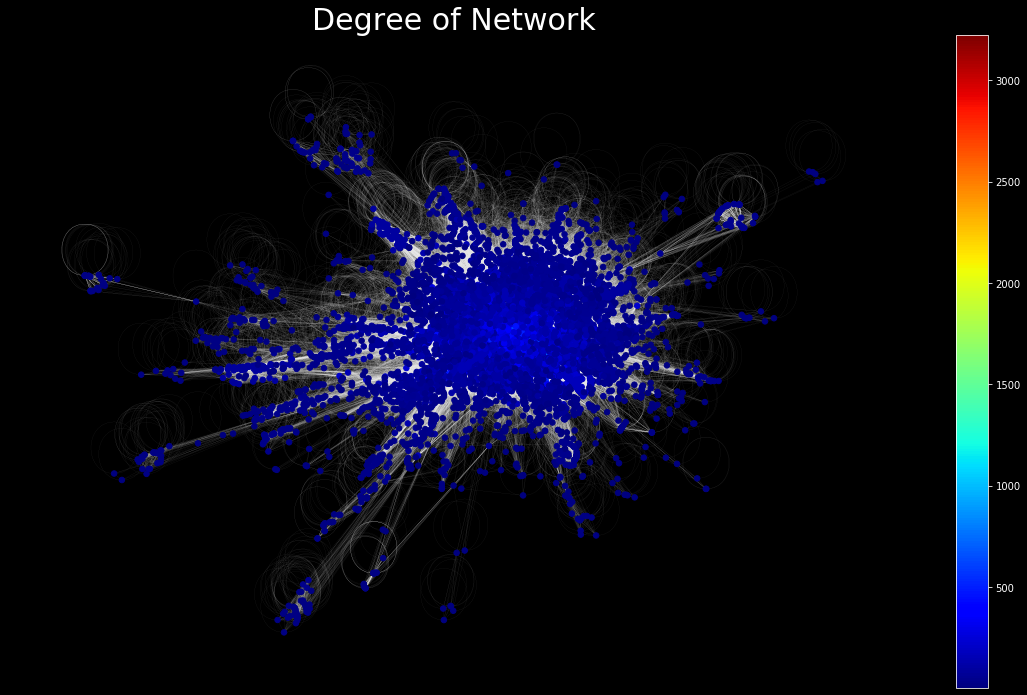

In [ ]:
plt.style.use("dark_background")

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

# the degree of network(Gcc)
fig, ax = plt.subplots(1,1,figsize=(20,12))

# layout position
#pos = nx.spring_layout(g,seed=123456789)

# draw edges
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.05,
                       alpha=0.6, 
                       ax=ax,
                       edge_color='white')

# draw nodes
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_degree,
                 cmap=plt.cm.jet,
                 ax=ax,
                 node_size=30)

# draw labels
#nx.draw_networkx_labels(Gcc, pos=pos,
#                        font_color='white', ax=ax)

plt.title("Degree of Network", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.savefig('degree.jpg', dpi=300)
plt.show()

O plot nos diz que a maioria dos Nodes possuem até 1000 Degrees. Por existir alguns Nodes com valor alto, cerca de 3000, acabou enviesando o plot. Vamos conferir numa Probability Dense Function (PDF) a distribuição dos Degrees da network

### 2.2 Probability Dense Function (PDF)

Agora temos uma real visualização de como está distribuindo o Degree da rede, sendo que mais de 8000 artistas estão concentrados em até 250 vizinhos/conexões. É possível também visualizar no lado direito do gráfico a probabilidade de haver um Node com esse número de vizinhos

In [31]:
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

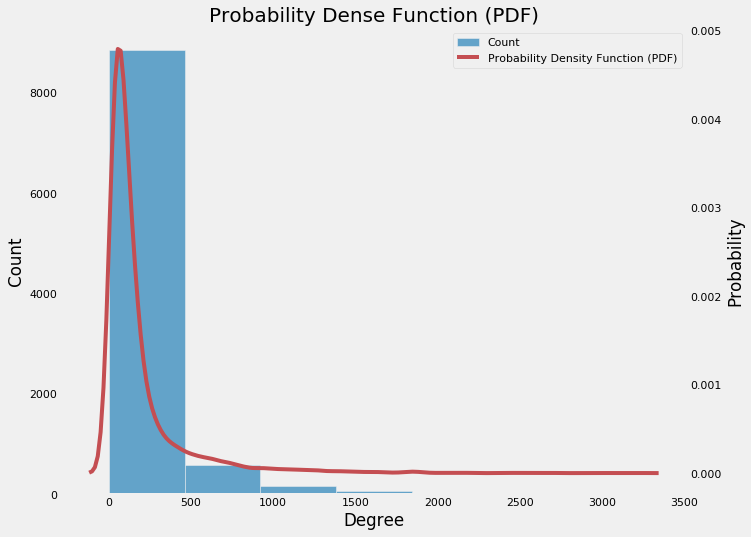

In [ ]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(10,8))
sns.histplot(color_degree,label="Count",ax=ax,bins=7)
ax2 = ax.twinx()
sns.kdeplot(color_degree,color='r',label="Probability Density Function (PDF)",ax=ax2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")
plt.title("Probability Dense Function (PDF)", fontsize = 20)
plt.savefig('probability_density_function.jpg', dpi=300,bbox_inches="tight")
plt.show()

### 2.3 Cumaltive Dense Function (CDF)

Podemos ter uma visualização similar considerando uma Cumaltive Dense Function (CDF). A CDF permite ver a porcentagem de Degree na forma acumulada. Vemos que cerca de 98% dos artistas tem Degree 1000 ou menor

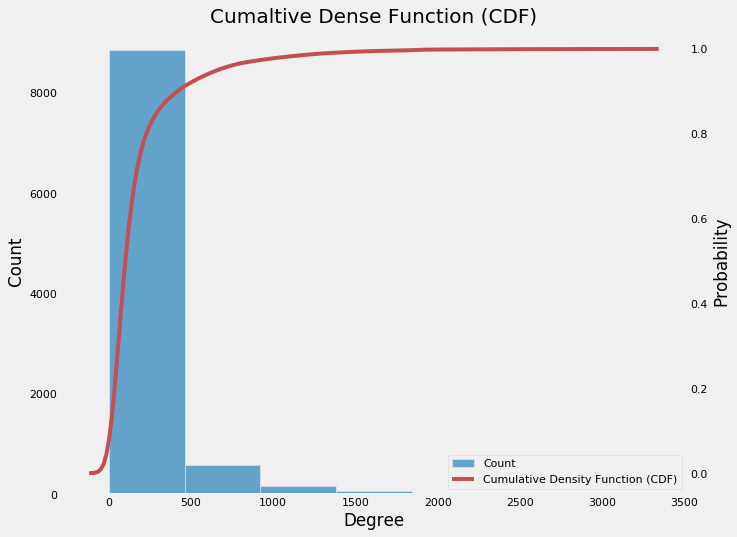

In [ ]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(color_degree,label="Count",ax=ax,bins=7)
ax2 = ax.twinx()
sns.kdeplot(color_degree,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")
plt.title("Cumaltive Dense Function (CDF)", fontsize = 20)
plt.savefig("cumulative_density_function.jpg",dpi=300,bbox_inches="tight")
plt.show()

Outra possibilidade de visualização da CDF é na escala logarítmica. O uso da escala logarítmica é eficiente quando temos uma escala de grandeza. Visualizar em log permite comparar com outras redes mesmo que menores graças ao uso de ordem grandeza.

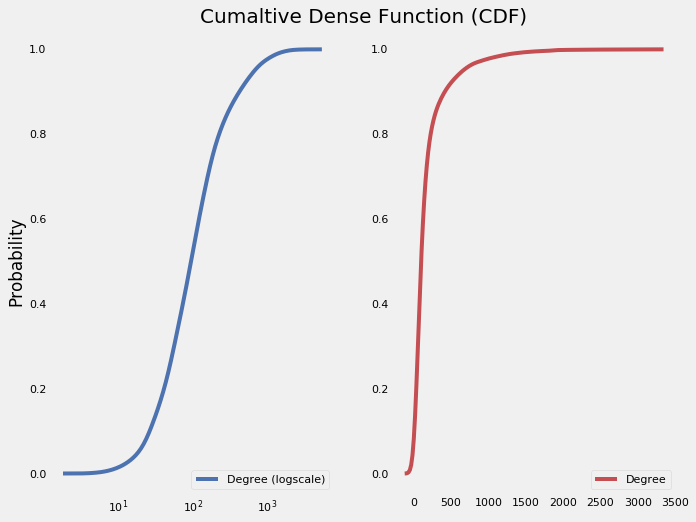

In [ ]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,2,figsize=(10,8))

sns.kdeplot(color_degree,color='b',label="Degree (logscale)",ax=ax[0],cumulative=True,log_scale=True)
ax[0].grid(False)
ax[0].legend(loc="lower right")
ax[0].set_ylabel("Probability")

sns.kdeplot(color_degree,color='r',label="Degree",ax=ax[1],cumulative=True,log_scale=False)
ax[1].grid(False)
ax[1].set_ylabel("")
ax[1].legend(loc="lower right")

plt.title("Cumaltive Dense Function (CDF)", fontsize = 20, x=-0.1, y=1.0)
plt.savefig('comparative_cdf_log.jpg', dpi=300,bbox_inches="tight")
plt.show()

## Step 3 | Node Ranking: Degree, Closeness, Betweenness and Eigenvector Centrality

### 3.1 Degree Centrality

In [15]:
# color of nodes
color_degree_centrality = list(dict(nx.degree_centrality(Gcc)).values())

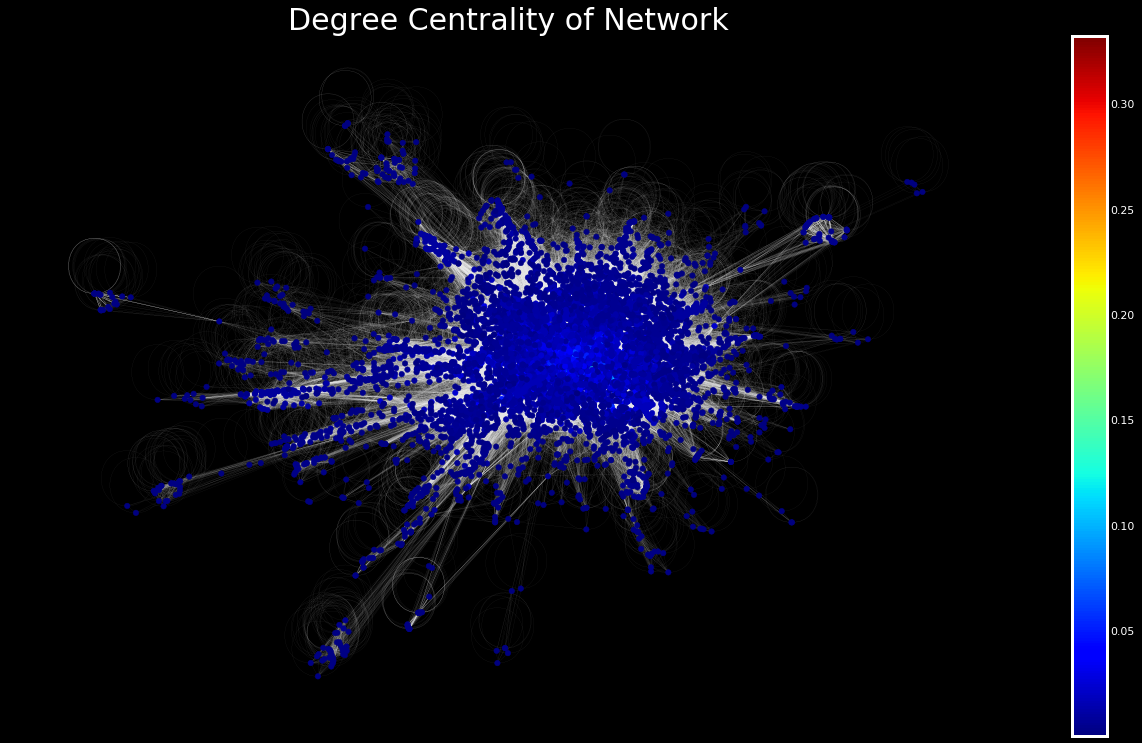

In [ ]:
plt.style.use("dark_background")

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

COLOR = 'white'
plt.rcParams['text.color'] = COLOR

# the degree centrality of network(Gcc)
fig, ax = plt.subplots(1,1,figsize=(20,12))

#layout position
#pos = nx.spring_layout(g,seed=123456789,k=0.3)

# draw edges
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.05,
                       alpha=0.6, 
                       ax=ax,
                       edge_color='white')
# draw nodes
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_degree_centrality,
                 cmap=plt.cm.jet,
                 ax=ax,
                 node_size=30)

# draw labels
#nx.draw_networkx_labels(g, pos=pos,
#                        font_color='white', ax=ax)

plt.title("Degree Centrality of Network", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.savefig('degree_centrality.jpg',dpi=300)
plt.show()

Degree Centrality é o número de conexões de um Node, a idéia é similar ao Degree. Muda o cálculo. 

Degree Centrality é o Grau do Node dividido pelo número de Nodes - 1

De forma similar, temos o top 20 de Degree Centrality

In [ ]:
i=0
for k, v in sorted(nx.degree_centrality(Gcc).items(), key=lambda x: x[1],reverse=True):
  print(k,v)
  if i == 20:
    break
  i+=1

Drake 0.3321988448844885
Rihanna 0.31518151815181517
Kanye West 0.2783622112211221
The Weeknd 0.2750618811881188
Coldplay 0.2671204620462046
The Chainsmokers 0.2583539603960396
Kendrick Lamar 0.25216584158415845
Calvin Harris 0.24896864686468648
Maroon 5 0.22566006600660066
Ed Sheeran 0.22246287128712872
Major Lazer 0.2214315181518152
Justin Bieber 0.21400577557755776
Twenty One Pilots 0.21235561056105612
Imagine Dragons 0.20823019801980197
Sia 0.20193894389438943
DJ Snake 0.1987417491749175
J. Cole 0.1952351485148515
Vance Joy 0.1948226072607261
Future 0.19461633663366337
Lil Wayne 0.19348184818481848
Ariana Grande 0.19337871287128713


### 3.2 Closeness Centrality

In [ ]:
# color of nodes
color_closeness_centrality = list(dict(nx.closeness_centrality(Gcc)).values())

In [ ]:
joblib.dump(color_closeness_centrality, 'color_closeness_centrality.pkl')
#color_closeness_centrality

In [16]:
color_closeness_centrality = joblib.load('color_closeness_centrality.pkl', mmap_mode='r')

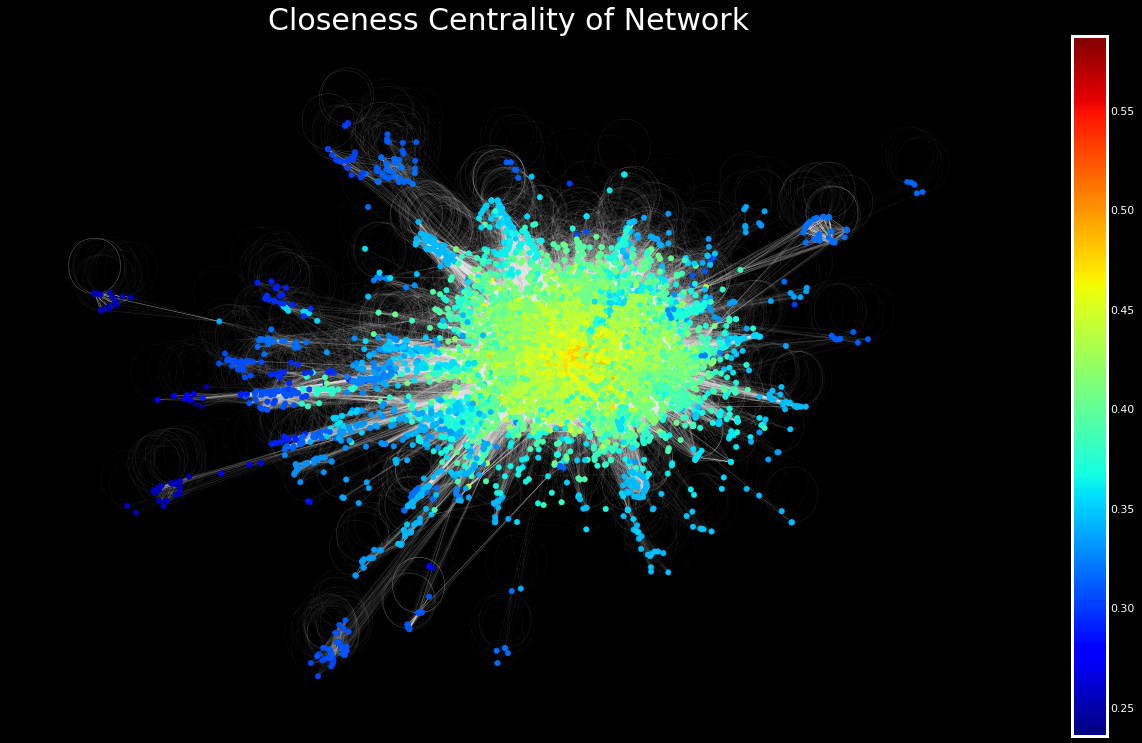

In [ ]:
plt.style.use("dark_background")

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

# the closeness centrality of network(Gcc)
fig, ax = plt.subplots(1,1,figsize=(20,12))

# layout position
#pos = nx.spring_layout(g,seed=123456789,k=0.3)

# draw edges
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.05,
                       alpha=0.6, 
                       ax=ax,
                       edge_color='white')

# draw nodes
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_closeness_centrality,
                 cmap=plt.cm.jet,
                 ax=ax,
                 node_size=30)

# draw labels
#nx.draw_networkx_labels(g, pos=pos,
#                        font_color='white', ax=ax)


plt.axis("off")
plt.colorbar(nodes)
plt.title("Closeness Centrality of Network", fontsize = 30)
plt.savefig('closeness_centrality.jpg',dpi=300)
plt.show()

Closeness Centrality é a métrica que informa a distância média de todos os Nodes para um Node. 

Se a métrica retornar um número pequeno, significa que um Node está longe dos outros Nodes. Por consequência, quanto maior o valor, mais próximo de todos os Nodes da network.

Essa métrica se torna interessante se você quer propagar uma informação, você pode enviar a esses Nodes que ela vai ser difundida mais rápido.

No plot vemos que na região central tem os Nodes com maior valor. Os que estão mais distantes do centro tem um valor de closeness menor, portanto são menos relevantes pro fluxo de tranmissão da rede

In [ ]:
closeness_centrality = nx.closeness_centrality(Gcc)

Top 20 Nodes com maior valor de Closeness Centrality

In [ ]:
i=0
for k, v in sorted(closeness_centrality.items(), key=lambda x: x[1],reverse=True):
  print(k,v)
  if i == 20:
    break
  i+=1

Drake 0.5875295400836211
Rihanna 0.5848009650180941
The Weeknd 0.567814476458187
Kanye West 0.5654963256736265
Coldplay 0.5652985074626866
The Chainsmokers 0.5575618171362853
Kendrick Lamar 0.5567294441892513
Calvin Harris 0.5551674778127684
Maroon 5 0.5490995582738702
Ed Sheeran 0.548944120477835
Justin Bieber 0.5484473103682335
Sia 0.5434672944341685
Imagine Dragons 0.5432845856446462
Twenty One Pilots 0.5403477485510477
Major Lazer 0.5400467862314805
Ariana Grande 0.5392958451526781
Adele 0.5378300421566452
Bruno Mars 0.5375318771482426
Lil Wayne 0.5375318771482426
JAY Z 0.5364612150049796
Selena Gomez 0.536283185840708


### 3.3 Betwenness Centrality

In [ ]:
# color of nodes
color_betweenness_centrality = list(dict(nx.betweenness_centrality(Gcc)).values())

In [ ]:
joblib.dump(color_betweenness_centrality, 'color_betweenness_centrality.pkl')

In [17]:
color_betweenness_centrality = joblib.load('color_betweenness_centrality.pkl', mmap_mode='r')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


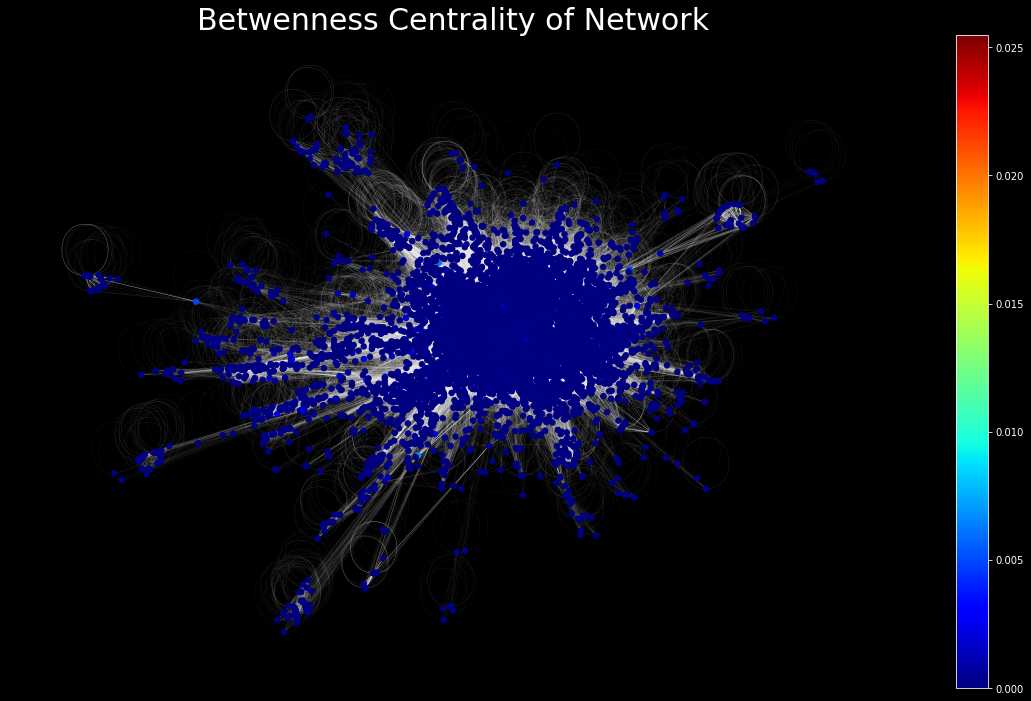

In [5]:
plt.style.use("dark_background")

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

# the betwenness centrality of network(Gcc)
fig, ax = plt.subplots(1,1,figsize=(20,12))

# layout position
#pos = nx.spring_layout(g,seed=123456789,k=0.3)


# draw edges
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.05,
                       alpha=0.6, 
                       ax=ax,
                       edge_color='white')
# draw nodes
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_betweenness_centrality,
                 cmap=plt.cm.jet,
                 ax=ax,
                 node_size=30)
# draw labels
#nx.draw_networkx_labels(g, pos=pos,
#                        font_color='white', ax=ax)

plt.title("Betwenness Centrality of Network", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.savefig('betweenness_centrality.jpg', dpi=300)
plt.show()

O Betwenness Centrality informa a porcentagem de small paths (caminhos curtos) que um Node faz parte. Essa métrica da uma idéia de ponte. Se esse Node está sempre fazendo parte do fluxo da informação.

Quanto maior o valor, mais o Node é importante no fluxo da network. Plot não ajudou tanto em descobrir quais são os Nodes mais importantes, mas temos que a maioria tem significância nula.

In [ ]:
#Aqui tive que fazer uma improvisação. Essa métrica é muito custosa de calcular. 
#Vamos aproveitar os valores achados no color
betweenness_centrality = {}
for node, value in zip(list(Gcc.nodes()),color_betweenness_centrality):
  betweenness_centrality[node] = value
#Ou você pode executar os códigos abaixo que vai trazer exatemente o mesmo resultado

In [ ]:
betweenness_centrality = nx.betweenness_centrality(Gcc)

In [ ]:
color_betweenness_centrality

Top 20 Nodes com maior Betwenness Centrality

In [14]:
i=0
for k, v in sorted(betweenness_centrality.items(), key=lambda x: x[1],reverse=True):
  print(k,v)
  if i == 20:
    break
  i+=1

Rihanna 0.02546421256926004
Drake 0.021178451429365124
Coldplay 0.016328097515866957
The Weeknd 0.012797519436765789
Kanye West 0.01259749929120701
The Chainsmokers 0.011644817985096059
Kendrick Lamar 0.011553116219782656
Calvin Harris 0.01060036146524998
Justin Bieber 0.009546028148909319
Twenty One Pilots 0.009068817328599788
OutKast 0.0089890596417808
Ed Sheeran 0.008107226930811529
Maroon 5 0.007988575643116374
Major Lazer 0.007687399023474193
Marvin Gaye 0.007327675210661379
Lana Del Rey 0.006880408481982434
Hans Zimmer 0.006876965355253465
Seu Jorge 0.006830451818858655
Bruno Mars 0.006661112001873667
Michael Bublé 0.006636309732842121
Wiz Khalifa 0.006490601230707645


### 3.4 Eigenvector Centrality

In [19]:
# color of nodes
color_eigenvector_centrality = list(dict(nx.eigenvector_centrality(Gcc)).values())

In [ ]:
joblib.dump(color_eigenvector_centrality, 'color_eigenvector_centrality.pkl')

In [ ]:
color_eigenvector_centrality = joblib.load('color_eigenvector_centrality.pkl', mmap_mode='r')

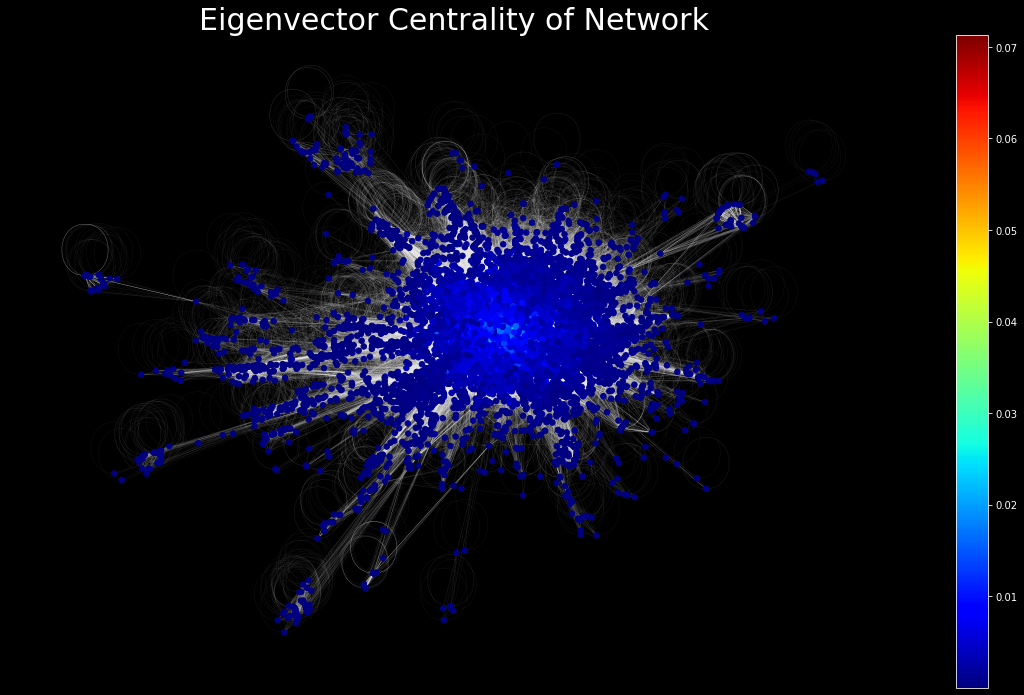

In [ ]:
plt.style.use("dark_background")

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

# the eigenvector centrality of network(Gcc)
fig, ax = plt.subplots(1,1,figsize=(20,12))

# layout position
#pos = nx.spring_layout(g,seed=123456789,k=0.3)

# draw edges
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.05,
                       alpha=0.6, 
                       ax=ax,
                       edge_color='white')

# draw nodes
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_eigenvector_centrality,
                 cmap=plt.cm.jet,
                 ax=ax,
                 node_size=30)

# draw labels
#nx.draw_networkx_labels(g, pos=pos,
#                        font_color='white', ax=ax)

plt.title("Eigenvector Centrality of Network", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.savefig('eigenvector_centrality.jpg',dpi=300)
plt.show()

Eigenvector (Auto-Vetor) Centrality verifica se um Node tem como vizinhos nós importantes. No plot praticamente todos tem vizinhos poucos ou nenhum importantes. Na parte central do grafo estão os Nodes com maior Eigenvector Centrality

In [ ]:
eigenvector_centrality = nx.eigenvector_centrality(Gcc)

Top 20 Nodes com maior Betwenness Centrality

In [ ]:
i=0
for k, v in sorted(eigenvector_centrality.items(), key=lambda x: x[1],reverse=True):
  print(k,v)
  if i == 20:
    break
  i+=1

Drake 0.0712437732375942
Rihanna 0.07075663717851959
The Weeknd 0.06569488815842768
Kanye West 0.0656556128342308
The Chainsmokers 0.06316037550825865
Calvin Harris 0.061990107092988765
Coldplay 0.060600822708681515
Maroon 5 0.06028091298414108
Kendrick Lamar 0.05946442248017485
Ed Sheeran 0.05846302043799837
Justin Bieber 0.05794870283911335
Major Lazer 0.05734101427891114
Miley Cyrus 0.05704382772614686
Imagine Dragons 0.05700475328650203
Sia 0.056701438077730384
DJ Snake 0.05611779696518167
Nicki Minaj 0.05590258111627488
Beyoncé 0.05572520489065653
Selena Gomez 0.05564809507844206
Bruno Mars 0.0554852202306783
J. Cole 0.055429170092460796


### 3.5 All Together

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


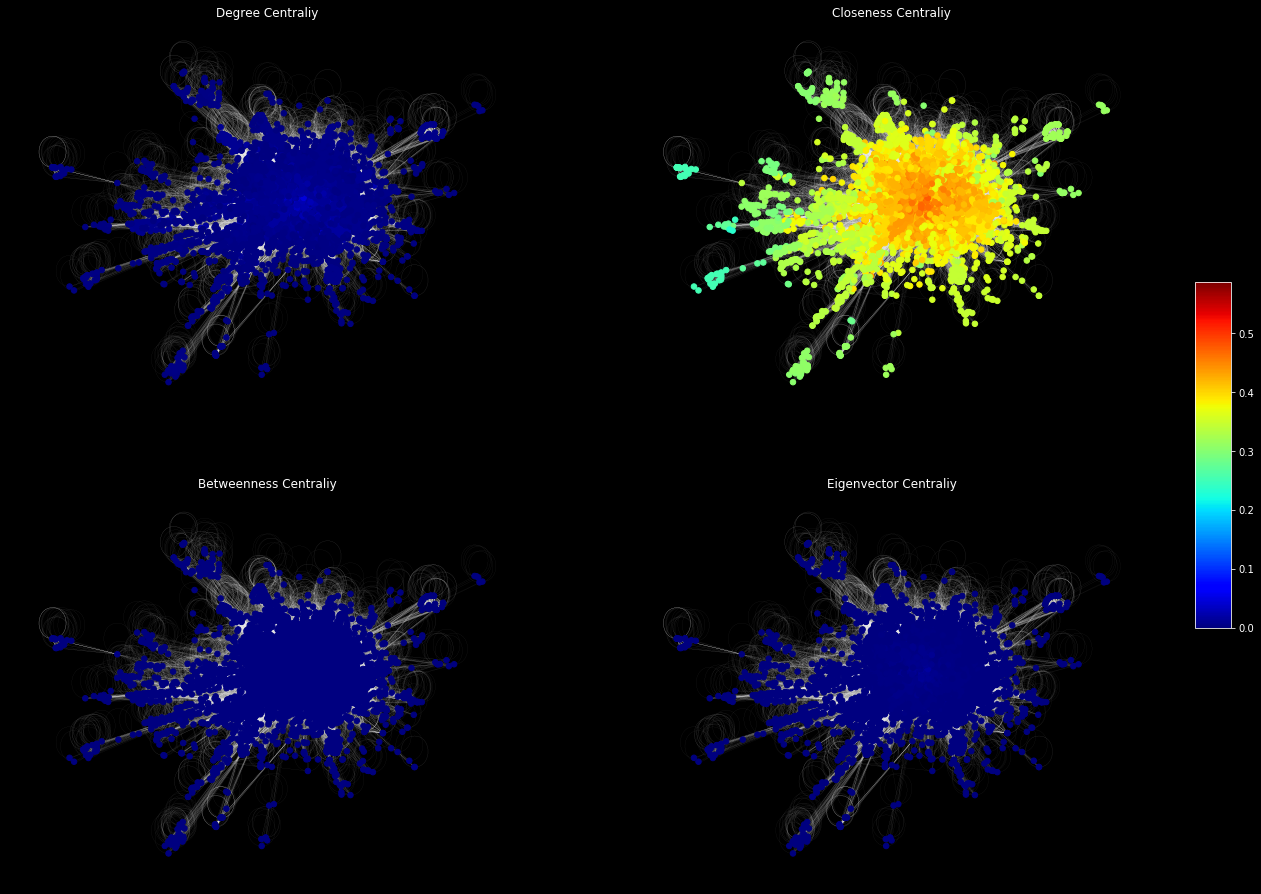

In [21]:
plt.style.use("dark_background")

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

# the eigenvector centrality of network(g)
fig, ax = plt.subplots(2,2,figsize=(20,12))

# max value of metrics 
max_centrality = max([max(color_betweenness_centrality),
                      max(color_closeness_centrality),
                      max(color_degree_centrality),
                      max(color_eigenvector_centrality)])

# layout position
#pos = nx.spring_layout(g,seed=123456789,k=0.3)


# 
# draw edges
#
# degree centrality
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.05,
                       alpha=0.6, 
                       ax=ax[0,0],
                       edge_color='white')

# closeness centrality
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.05,
                       alpha=0.6, 
                       ax=ax[0,1],
                       edge_color='white')

# betweenness centrality
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.05,
                       alpha=0.6, 
                       ax=ax[1,0],
                       edge_color='white')

# eigenvector centrality
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.05,
                       alpha=0.6, 
                       ax=ax[1,1],
                       edge_color='white')

# draw nodes
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_degree_centrality,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[0,0],
                 node_size=30)
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_closeness_centrality,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[0,1],
                 node_size=30)
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_betweenness_centrality,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[1,0],
                 node_size=30)
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color=color_eigenvector_centrality,
                 cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                 ax=ax[1,1],
                 node_size=30)

# 
# draw labels
#
#nx.draw_networkx_labels(Gcc, pos=pos,
#                        font_color='white', ax=ax[0,0])
#nx.draw_networkx_labels(Gcc, pos=pos,
#                        font_color='white', ax=ax[0,1])
#nx.draw_networkx_labels(Gcc, pos=pos,
#                        font_color='white', ax=ax[1,0])
#nx.draw_networkx_labels(Gcc, pos=pos,
#                        font_color='white', ax=ax[1,1])

# eliminate axis
ax[0,0].axis("off")
ax[1,0].axis("off")
ax[0,1].axis("off")
ax[1,1].axis("off")

ax[0,0].set_title("Degree Centraliy")
ax[0,1].set_title("Closeness Centraliy")
ax[1,0].set_title("Betweenness Centraliy")
ax[1,1].set_title("Eigenvector Centraliy")


# Create an unique colorbar
# reference: https://stackoverflow.com/questions/60848582/unique-colorbar-at-the-right-of-multiple-subplots
plt.subplots_adjust(bottom=0., right=0.92, top=1.)
cax = plt.axes([0.95, 0.3, 0.025, 0.4])
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=max_centrality))
cbar=plt.colorbar(sm,cax)
plt.savefig('comparing_centrality_metrics.jpg',dpi=300,bbox_inches="tight")
plt.show()

## Step 4 | Multi Variate Analysis

In [22]:
betweenness_centrality = {}
for node, value in zip(list(Gcc.nodes()),color_betweenness_centrality):
  betweenness_centrality[node] = value

closeness_centrality = {}
for node, value in zip(list(Gcc.nodes()),color_closeness_centrality):
  closeness_centrality[node] = value

eigenvector_centrality = {}
for node, value in zip(list(Gcc.nodes()),color_eigenvector_centrality):
  eigenvector_centrality[node] = value

degree_centrality = {}
for node, value in zip(list(Gcc.nodes()),color_degree_centrality):
  degree_centrality[node] = value

In [24]:
df_mva = pd.DataFrame.from_dict({"Betweenness": betweenness_centrality,
                            "Degree": degree_centrality,
                            "EigenVector": eigenvector_centrality,
                            "Closeness": closeness_centrality})
df_mva.reset_index(inplace=True,drop=True)
df_mva.head()

Betweenness    Degree  EigenVector  Closeness
0     0.000856  0.092306     0.035948   0.501863
1     0.003819  0.189356     0.055725   0.535957
2     0.000289  0.063016     0.025464   0.489672
3     0.000293  0.067657     0.023681   0.488537
4     0.000878  0.117059     0.043009   0.506557

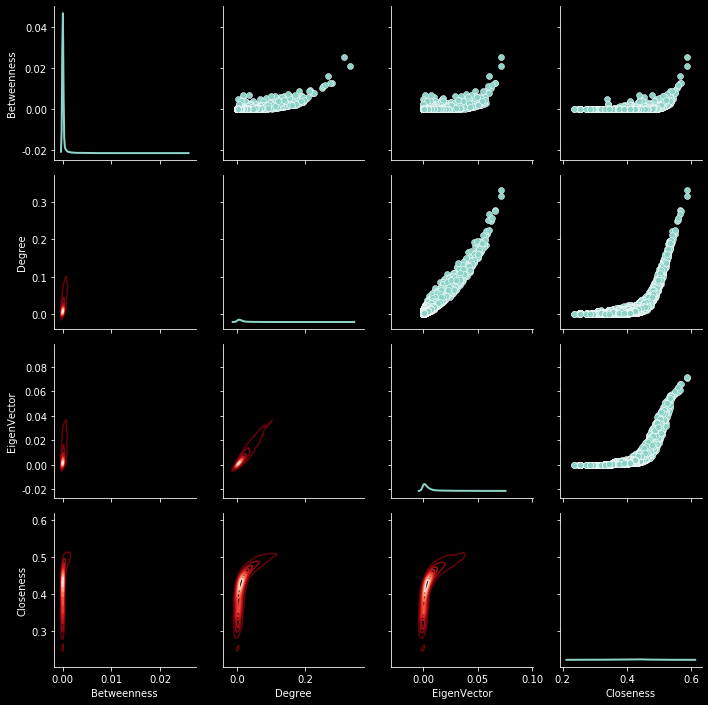

In [25]:
fig = sns.PairGrid(df_mva)
fig.map_upper(sns.scatterplot)
fig.map_lower(sns.kdeplot, cmap="Reds_r")
fig.map_diag(sns.kdeplot, lw=2, legend=False)

plt.savefig('multivariate_analysis.jpg', dpi=300,bbox_inches="tight")
plt.show()

Na PDF [1,1] mostra uma grande quantidade de Nodes com baixo Betwenness. Poucos Nodes com um valor um pouco superior. Expõe os Hubs da network. As outras três PDF de Degree [2,2], EigenVector [3,3] e Closeness [4,4] não tem destaques.
Em [1,2] quando eu tenho um aumento no Degree, também é aumentada o Betwenness. Logo, quando eu atinjo um certo número de Degree ele passa a ser mais importante para o fluxo da network. Em [1,3] e [1,4] esse formato de aumento de Betwenness é bem semelhante.
Em [2,3] quando eu tenho um crescimento do EigenVector, o Degree acaba crescendo de forma linear. Ou seja, quando mais um Node tem vizinhos importantes, mais vizinhos ele vai tendo.
Já em [2,4], o Degree tem um ganho quando o Closeness supera o valor de 0.4. Após ele atingir um alto valor de proximidade a todos os Nodes, ele passa a ter um ganho de Degree.
Esse mesmo movimento de crescimento visto em [2,4] é repetido para [3,4]. Quando a proximidade aumenta, ele passa a ter muitos vizinhos importantes.
Os outros são apenas a mesma representação só que no formado do KDE bivariado.

## Step 5 | Core Decomposition

### K-Core and K-Shell

O K-Core de um grafo é o subgrafo máximo tal que todo vértice tem grau de pelo menos k. O K-Shell é o conjunto de vértices que fazem parte do K-Core, mas não fazem parte do (K +1)-Core. Ela nos permite visualizar quem está no núcleo da network. (https://www.johndcook.com/blog/2016/01/25/understanding-a-graph-by-peeling-away-nodes/)



Funcionamento: É um método iterativo. A cada iteração ele verifica o grau dos Nodes, se for igual ao valor da iteração é retirado da rede. Se, ao retirar um Node o vizinho dele passar a ser do grau da iteração, ele também vai ser removido. 

Ao termino das remoções, teremos o N-Shell que foram nos Nodes removidos. O algoritmo termina quando a iteração atinge o valor suficiente que eliminaria todos os Nodes.

Em resumo, o K-Core vai ser Nodes pós remoção, e o (K-1)-Shell será os Nodes do K-Core mais os removidos dessa iteração

Essa análise não permite selfloops

In [28]:
Gcc.remove_edges_from(nx.selfloop_edges(Gcc))

Wow, muitos k-cores. Tem até 237

In [ ]:
len(set([v for k,v in nx.core_number(Gcc).items()]))

237

O máximo valor também é 237. Logo varia de 1 - 237

In [ ]:
max(set([v for k,v in nx.core_number(Gcc).items()]))

237

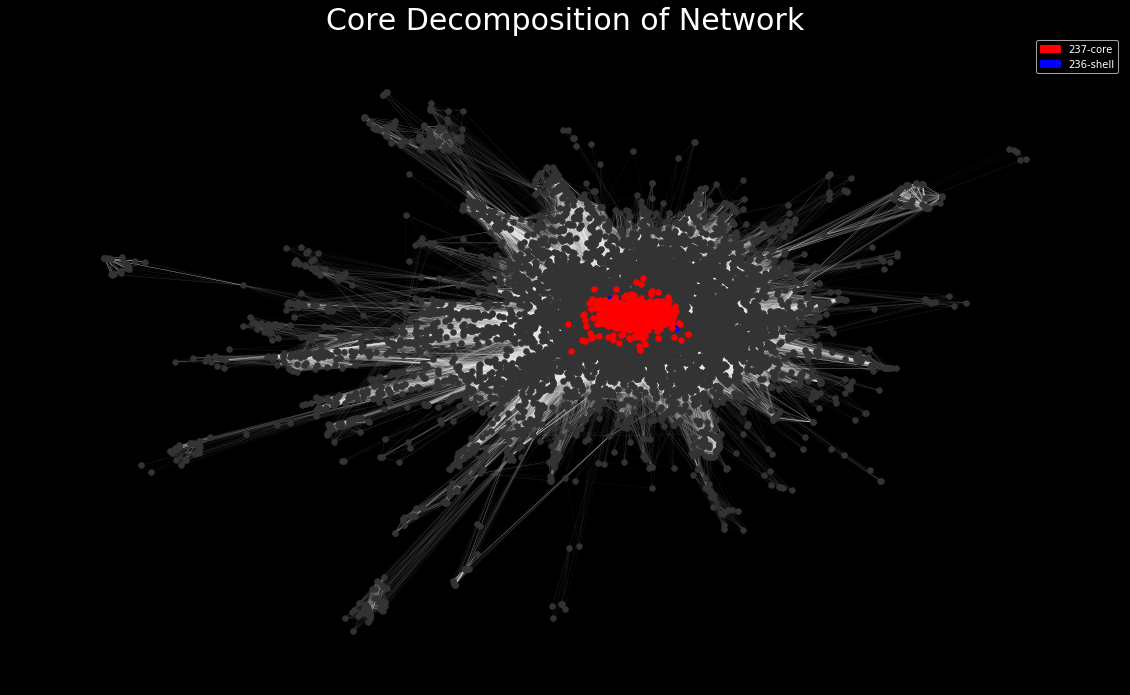

In [ ]:
plt.style.use("dark_background")

plt.rcParams['font.sans-serif']=['SimHei'] #Show Chinese label
plt.rcParams['axes.unicode_minus']=False   #These two lines need to be set manually

fig, ax = plt.subplots(1,1,figsize=(20,12))

# Find k-cores
Gcc_core_236 = nx.k_shell(Gcc, 236)
Gcc_core_237 = nx.k_core(Gcc, 237)

# layout position
#pos = nx.spring_layout(g2,seed=123456789,k=0.3)

# draw edges
nx.draw_networkx_edges(Gcc,
                       pos=pos,
                       width=0.05,
                       alpha=0.6, 
                       ax=ax,
                       edge_color='white')

# draw nodes
nodes = nx.draw_networkx_nodes(Gcc,
                 pos=pos,
                 node_color="#333333",
                 ax=ax,
                 node_size=30)

# draw nodes
nodes = nx.draw_networkx_nodes(Gcc_core_236,
                 pos=pos,
                 node_color="blue",
                 ax=ax,
                 node_size=30)

nodes = nx.draw_networkx_nodes(Gcc_core_237,
                 pos=pos,
                 node_color="red",
                 ax=ax,
                 node_size=30)

# static legend
blue_patch = mpatches.Patch(color='blue', label='236-shell')
red_patch = mpatches.Patch(color='red', label='237-core')
plt.legend(handles=[red_patch,blue_patch])
plt.title("Core Decomposition of Network", fontsize = 30)
plt.axis("off")
plt.savefig('core-decomposition.jpg',dpi=300)
plt.show()

Nosso GCC tem 237 níveis até chegar o núcleo da network. Eles estão concentrados no centro do grafo. Possível visualizar alguns Nodes do K-Shell.

In [ ]:
K_core = set(nx.k_core(Gcc,237))

In [ ]:
K_shell = set(nx.k_shell(Gcc,236))

In [ ]:
len(K_shell),len(K_core)

(8, 561)

Os Nodes que foram removidos no último nível

In [ ]:
for i in K_shell:
  print(i)

O.T. Genasis
Playboi Carti
Mayday Parade
Buckcherry
Whitney Houston
DJ Luke Nasty
Old Crow Medicine Show
Eric Church


Os Nodes pertencentes ao Núcleo da rede. Cada um deles contendo pelo menos 237 vizinhos

In [ ]:
for i in K_core:
  print(i)

Toby Keith
Alex & Sierra
Olly Murs
Sammy Adams
OutKast
Jon Bellion
Alabama Shakes
Chingy
Gryffin
Iggy Azalea
The White Stripes
Diddy
Youngbloodz
Arctic Monkeys
2 Chainz
Passenger
Troye Sivan
The All-American Rejects
The Fray
Astrid S
Panic! At The Disco
Julia Michaels
3OH!3
LANY
Shoffy
T-Wayne
Bruce Springsteen
Fitz and The Tantrums
Florence + The Machine
Montell Jordan
Lil' Kim
Weezer
Iyaz
Pharrell Williams
5 Seconds of Summer
Lady Antebellum
Nelly
AWOLNATION
Brett Eldredge
Neil Diamond
Disclosure
Diplo
Beck
Pitbull
DNCE
Skillet
Flo Rida
SZA
Dua Lipa
Plain White T's
Michael Jackson
Tim McGraw
Tove Styrke
Twenty One Pilots
Cardi B
Young Thug
Darius Rucker
Gwen Stefani
Jessie J
Jack Johnson
Baby Bash
Natasha Bedingfield
Bon Iver
The Neighbourhood
Big Sean
Earth, Wind & Fire
Sleeping At Last
Kid Rock
Snakehips
Chiddy Bang
Guns N' Roses
Ne-Yo
Desiigner
Imagine Dragons
Johnny Cash
Gotye
Taio Cruz
Missy Elliott
Ella Henderson
Duke Dumont
Journey
Billy Joel
The Vamps
alt-J
Logic
Mike Jones
A

### GCC vs K-Core

In [29]:
color_degree_k_core_237 = list(dict(nx.degree(nx.k_core(Gcc,237))).values())

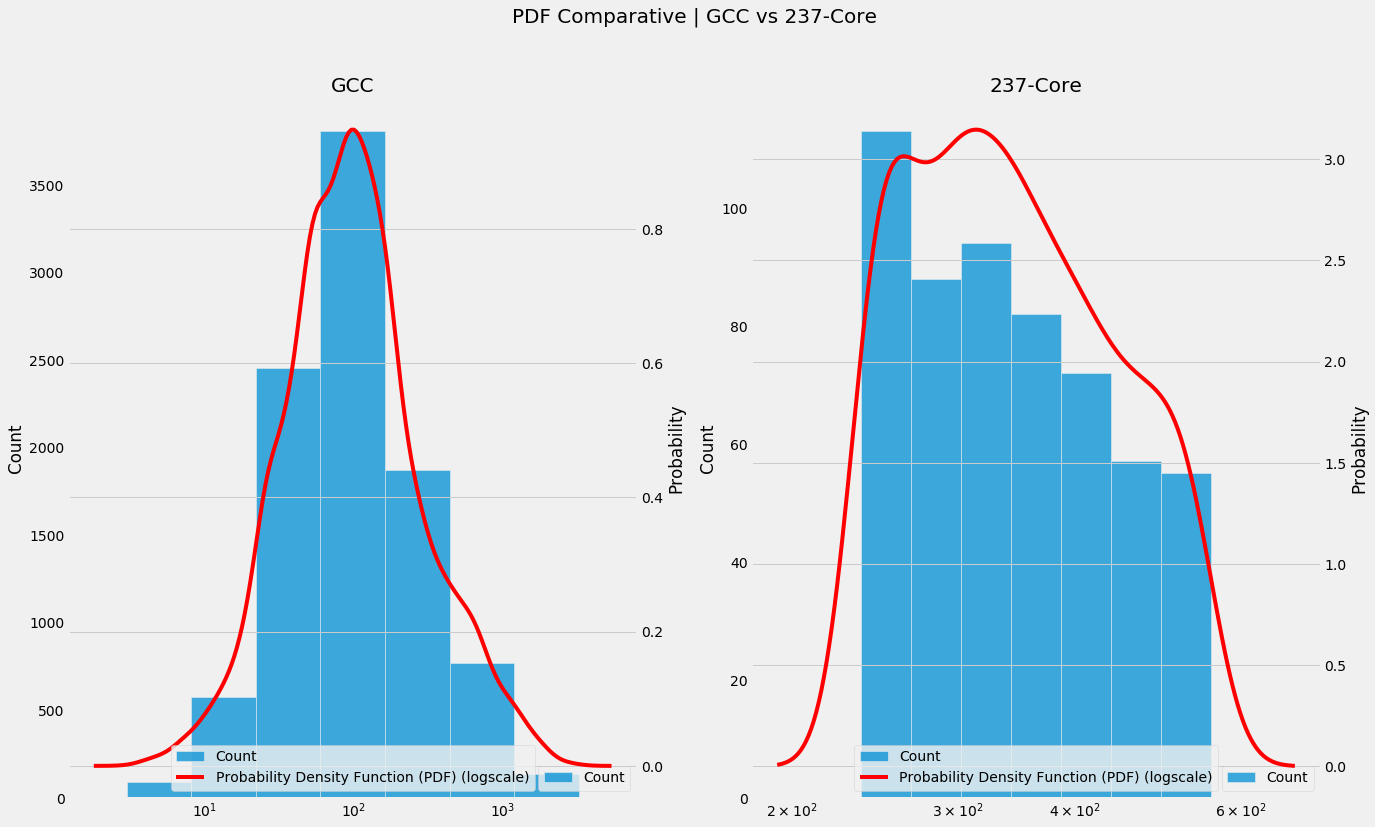

In [32]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,2,figsize=(20,12))

sns.histplot(color_degree,label="Count",ax=ax[0],bins=7,log_scale=True)
ax2 = ax[0].twinx()
sns.kdeplot(color_degree,color='r',label="Probability Density Function (PDF) (logscale)",ax=ax2)
ax[0].grid(False)
ax[0].legend(loc="lower right")
ax[0].set_ylabel("Count")

sns.histplot(color_degree_k_core_237,label="Count",ax=ax[1],bins=7,log_scale=True)
ax3 = ax[1].twinx()
sns.kdeplot(color_degree_k_core_237,color='r',label="Probability Density Function (PDF) (logscale)",ax=ax3)
ax[1].grid(False)
ax[1].set_ylabel("Count")
ax[1].legend(loc="lower right")


# ask matplotlib for the plotted objects and their labels
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

lines3, labels3 = ax[1].get_legend_handles_labels()
lines4, labels4 = ax2.get_legend_handles_labels()
ax3.legend(lines3 + lines4, labels3 + labels4, loc=0)

ax[0].title.set_text('GCC')
ax[1].title.set_text('237-Core')

ax2.set_ylabel("Probability")
ax3.set_ylabel("Probability")

plt.title("PDF Comparative | GCC vs 237-Core", fontsize = 20, x=-0.1, y=1.1)
plt.savefig('comparative-pdf-gcc-kcore.jpg', dpi=300,bbox_inches="tight")
plt.show()

Como falado anteriormente, o uso de escala Log permite comparar networks com tamanhos diferentes. Na distribuição do 237-Core o núcleo da rede não segue o padrão obtido na GCC. Enquanto a GCC tem o formato de uma Gaussiana (estão concentrados Nodes em torno da mediana), a 237-Core tem a cauda deslocada a esquerda. Um bom exercício seria descobrir qual foi o K-Core que fez a distribuição ficar similar a GCC

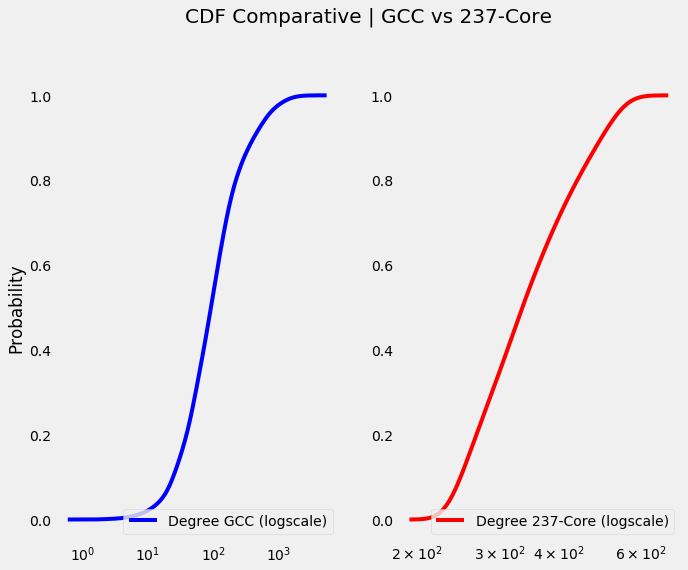

In [ ]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,2,figsize=(10,8))

sns.kdeplot(color_degree,color='b',label="Degree GCC (logscale)",ax=ax[0],cumulative=True,log_scale=True)
ax[0].grid(False)
ax[0].legend(loc="lower right")
ax[0].set_ylabel("Probability")

sns.kdeplot(color_degree_k_core_237,color='r',label="Degree 237-Core (logscale)",ax=ax[1],cumulative=True,log_scale=True)
ax[1].grid(False)
ax[1].set_ylabel("")
ax[1].legend(loc="lower right")

plt.title("CDF Comparative | GCC vs 237-Core", fontsize = 20, x=-0.1, y=1.1)
plt.savefig('comparative_cdf_core_decomposition_log.jpg', dpi=300,bbox_inches="tight")
plt.show()

A CDF são bastantes parecidas, a 237-Core acaba sendo um pouco mais linear. Ambas atingindo o total de Nodes quase próximas a última 

## Step 6 | Gephi

Como citado na descrição do trabalho, a network foi exportada no Gephi e está disponível no Github Pages (https://vilsonrodrigues.github.io/NetworkAnalysis/spotify-playlists/network)



Utilizamos a métrica chamada Modularity para encontrar as comunidades em que cada Node pertence. O algoritmo achou 19 comunidades diferentes. As cores representam a comunidade em que o Node está.

O layout de expansão da network foi o *ForceAtlas 2*. No plot, o tamanho de cada Node refere proporcionalmente ao número de Degree do artista.

Por último, foi exportado como um app Sigma e levado ao Pages


Assim é a interface do App. Os Nodes são interativos. É possível buscar por artista ou selecionar por comunidade

![](https://github.com/vilsonrodrigues/NetworkAnalysis/raw/main/spotify-playlists/images/grafo-github.jpg)

Aqui temos a busca pela artista Avril. No canto podemos ver os artistas que tem conexão com ela. O número da comunidade. E algumas métricas

![](https://github.com/vilsonrodrigues/NetworkAnalysis/raw/main/spotify-playlists/images/grafo-filter-by-node.jpg)

Filtro por comunidade

![](https://github.com/vilsonrodrigues/NetworkAnalysis/raw/main/spotify-playlists/images/graf--filter-by-community.jpg)